In [ ]:
# project : con1d vs transformer

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# TransformerLayer
class TransformerLayer(nn.Module):
  def __init__(self,embed_dim,num_heads,ff_dim):
    super().__init__()
    self.attention = nn.MultiheadAttention(embed_dim=embed_dim,num_heads=num_heads)
    self.feed_forward = nn.Sequential(
        nn.Linear(embed_dim,ff_dim),
        nn.ReLU(),
        nn.Linear(ff_dim,embed_dim)
    )
    self.norm1 = nn.LayerNorm(embed_dim)
    self.norm2 = nn.LayerNorm(embed_dim)

  def forward(self,x):
    attn_output,_ = self.attention(x,x,x)
    x = self.norm1(x + attn_output)
    ff_output = self.feed_forward(x)
    x = self.norm2(x + ff_output)
    return x



In [4]:
# Model
class ToyModel(nn.Module):
  def __init__(self,vocab_size,embed_dim,num_heads,ff_dim,num_classes):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,embed_dim)
    self.transformer1 = TransformerLayer(embed_dim,num_heads,ff_dim)
    self.transformer2 = TransformerLayer(embed_dim,num_heads,ff_dim)
    self.conv1d = nn.Conv1d(embed_dim,embed_dim // 2 , kernel_size = 3 , padding =1)
    self.fc = nn.Linear(embed_dim // 2 , num_classes)

  def forward(self,x):
    x = self.embedding(x)
    x = self.transformer1(x)
    embedding_before_conv = self.transformer2(x)
    x = embedding_before_conv.permute(0,2,1)
    x = self.conv1d(x)
    embedding_after_conv = x.permute(0,2,1)
    pooled_output = embedding_after_conv.mean(dim=1)
    logits = self.fc(pooled_output)
    return logits,embedding_before_conv,embedding_after_conv

In [5]:
# load IMDB dataset
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
  return tokenizer(examples["text"],padding="max_length",truncation=True,max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
tokenized_dataset = dataset.map(tokenize_function,batched=True)
tokenized_dataset=tokenized_dataset.remove_columns(["text","token_type_ids"])
tokenized_dataset = tokenized_dataset.rename_columns({ 'label' : 'labels'})

small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(10000))
small_test_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))



Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
# __train__
model = ToyModel(vocab_size=tokenizer.vocab_size,embed_dim=128,num_heads=4,ff_dim=256,num_classes=2)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
criterion = nn.CrossEntropyLoss()

def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [8]:
num_epochs = 3
for epoch in range(num_epochs):
  for batch in train_loader:
    optimizer.zero_grad()
    logits,_,_= model(batch["input_ids"])
    loss = criterion(logits,batch["labels"])
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{num_epochs} , Loss: {loss.item()}")

Epoch 1/3 , Loss: 0.5067298412322998
Epoch 2/3 , Loss: 0.6031464338302612
Epoch 3/3 , Loss: 0.5248277187347412


In [9]:
#  embeddings
def collate_fn(batch):
    return {
        'input_ids': torch.tensor([item['input_ids'] for item in batch]),
        'labels': torch.tensor([item['labels'] for item in batch])
    }

test_loader = torch.utils.data.DataLoader(small_test_dataset,batch_size=64,shuffle=False,collate_fn=collate_fn)
all_embeddings_before = []
all_embeddings_after = []
all_labels = []

In [10]:
with torch.no_grad():
  for batch in test_loader:
    _,embeddings_before , embeddings_after = model(batch["input_ids"])
    all_embeddings_before.append(embeddings_before[:,0,:].cpu().numpy())
    all_embeddings_after.append(embeddings_after[:,0,:].cpu().numpy())
    all_labels.extend(batch["labels"].cpu().numpy())

In [11]:
all_embeddings_before = np.concatenate(all_embeddings_before)
all_embeddings_after = np.concatenate(all_embeddings_after)
all_labels = np.array(all_labels)

In [12]:
print(f"Shape of all_embeddings_before: {all_embeddings_before.shape}")
print(f"Shape of all_embeddings_after: {all_embeddings_after.shape}")


Shape of all_embeddings_before: (1000, 128)
Shape of all_embeddings_after: (1000, 64)


# tsne + pca



embeddings_before_reduced.shape : (1000, 64)
all_embeddings_after.shape : (1000, 64)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


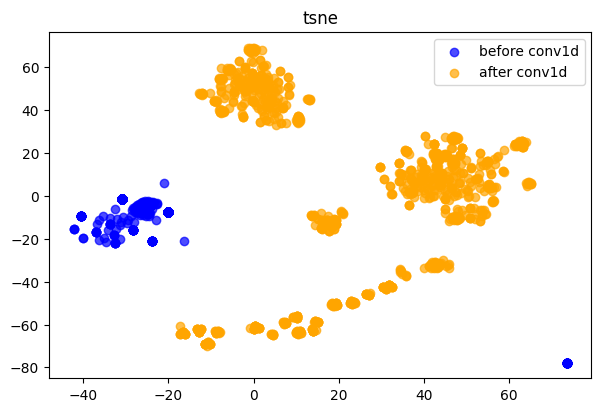

In [13]:
from sklearn.decomposition import PCA

target_dim = all_embeddings_after.shape[1]
pca = PCA(n_components = target_dim)
embeddings_before_reduced = pca.fit_transform(all_embeddings_before)

# اطلاعات عمومی
print(f"embeddings_before_reduced.shape : {embeddings_before_reduced.shape}")
print(f"all_embeddings_after.shape : {all_embeddings_after.shape}")

combined_embeddings = np.concatenate([embeddings_before_reduced,all_embeddings_after],axis=0)

pca2 = PCA(n_components =50)
combined_reduced = pca2.fit_transform(combined_embeddings)

tsne = TSNE(n_components=2,learning_rate=200,n_iter=1000,random_state=42)
tsne_result=tsne.fit_transform(combined_reduced)

half = len(embeddings_before_reduced)
tsne_before = tsne_result[:half]
tsne_after = tsne_result[half:]

plt.figure(figsize=(7,4.5))
plt.scatter(tsne_before[:,0],tsne_before[:,1],c='blue',label="before conv1d",alpha=0.7)
plt.scatter(tsne_after[:,0],tsne_after[:,1],c='orange',label="after conv1d",alpha=0.7)
plt.title("tsne")
plt.legend()
plt.show()